- Max Heading Difference between two consecutive waypoints
- Change in 1 second


# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
# dataDir = "/home/ababil/BUET/AV/location-2"
dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\Code\behavior-hypotheses\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [5]:
sceneId = 211
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [6]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        speedCol='speed',
        accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = 0.0,
    maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

using min Y displacement (5)


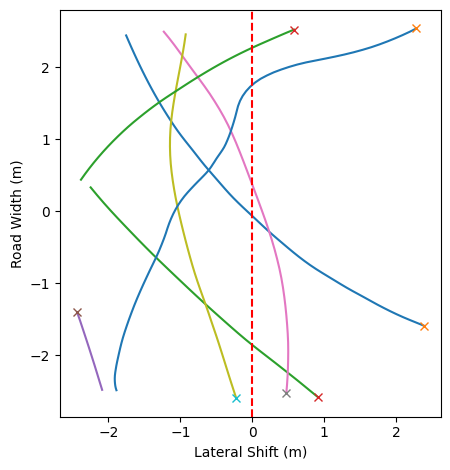

78

In [7]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


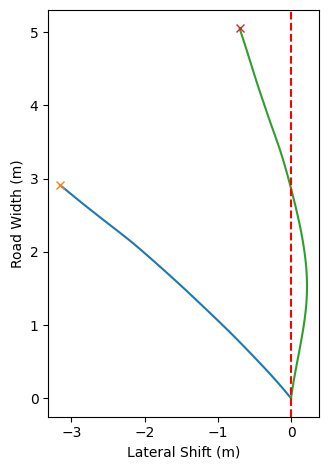

In [8]:
visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

### Right side of the vertical axis (clockwise) is negative

In [9]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
151,27,7286,27159,211,5.0,-0.925131,2.456394,0.073952,0.613293,-0.135421,0.017185,0.617735,0.826723,0.014625,0.136507,-0.000000,-0.000000
152,27,7288,27159,211,5.0,-0.943127,2.334856,0.089981,0.607688,-0.080143,0.028025,0.614313,0.808726,0.106913,0.084902,0.017996,0.121538
153,27,7290,27159,211,5.0,-0.963211,2.213789,0.100419,0.605334,-0.052192,0.011767,0.613607,0.788643,0.227980,0.053502,0.038080,0.242604
154,27,7292,27159,211,5.0,-0.984849,2.093201,0.108190,0.602943,-0.038852,0.011959,0.612572,0.767005,0.348568,0.040651,0.059718,0.363193
155,27,7294,27159,211,5.0,-1.007412,1.973067,0.112814,0.600667,-0.023121,0.011380,0.611169,0.744442,0.468701,0.025769,0.082281,0.483326
156,27,7296,27159,211,5.0,-1.030272,1.853356,0.114302,0.598555,-0.007442,0.010556,0.609371,0.721582,0.588413,0.012916,0.105141,0.603037
157,27,7298,27159,211,5.0,-1.052756,1.734014,0.112421,0.596710,0.009406,0.009224,0.607208,0.699097,0.707755,0.013174,0.127625,0.722379
158,27,7300,27159,211,5.0,-1.074216,1.614963,0.107299,0.595257,0.025607,0.007265,0.604851,0.677637,0.826806,0.026618,0.149085,0.841431
159,27,7302,27159,211,5.0,-1.094006,1.496114,0.098948,0.594245,0.041755,0.005061,0.602427,0.657848,0.945655,0.042061,0.168875,0.960280


In [10]:
# plt.boxplot(startingDf["speed"])

In [11]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

ZeroDivisionError: division by zero

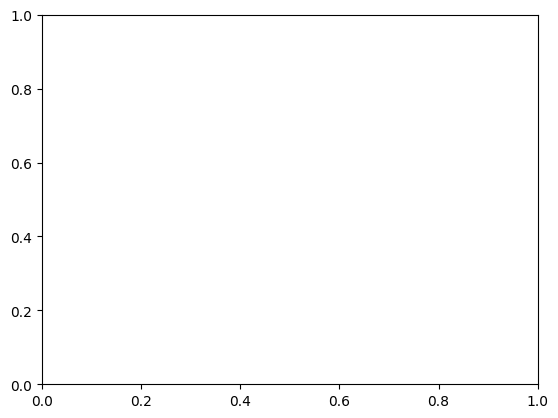

In [12]:
starting023 = startingDf[startingDf["uniqueTrackId"] == 18023].copy()
visualizer.show(starting023, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
# starting023.size
starting023

In [ ]:
angular023 = AngularDisplacementCalculator.addRelativeAngularDisplacement(starting023)
angular023

In [ ]:
angularStartingDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(startingDf)
angularStartingDf

In [13]:
# max absolute value of angular displacement
maxAngularDisplacement = angularStartingDf["relativeAngularDisplacement"].abs().max()
# get the rows with max angular displacement
maxAngularDisplacementDf = angularStartingDf[angularStartingDf["relativeAngularDisplacement"].abs() == maxAngularDisplacement].copy()
maxAngularDisplacementDf

NameError: name 'angularStartingDf' is not defined

In [14]:
# get the whole track of the pedestrian with max angular displacement
maxAngularDisplacementPedId = maxAngularDisplacementDf.iloc[0]["uniqueTrackId"]
maxAngularDisplacementPedDf = angularStartingDf[angularStartingDf["uniqueTrackId"] == maxAngularDisplacementPedId].copy()
maxAngularDisplacementPedDf

NameError: name 'maxAngularDisplacementDf' is not defined

In [15]:
def findMaxAngularDisplacementPedDf(df):
    angularDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(df)
    # get the max angular displacement
    maxAngularDisplacement = angularDf["absoluteAngularDisplacement"].max()
    # get the rows with max angular displacement
    maxAngularDisplacementDf = angularDf[angularDf["relativeAngularDisplacement"].abs() == maxAngularDisplacement].copy()
    return maxAngularDisplacementDf

findMaxAngularDisplacementPedDf(cleanPedDf)



,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement,absoluteAngularDisplacement
169,27,7322,27159,211,5.0,-1.085564,0.304545,-0.095337,0.600084,0.079995,-0.034642,0.60761,0.666289,2.137224,0.087174,0.160433,2.151848,0.784789,0.784789


In [16]:
# plot a graph between absolute angular displacement and speed at each datapoint
plt.scatter(angularStartingDf["speed"], angularStartingDf["absoluteAngularDisplacement"])

NameError: name 'angularStartingDf' is not defined

In [19]:
# categorize speed 
# 0-0.5, 0.5-1, 1-10
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])

In [21]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory
65,23,6059,23118,211,5.0,-2.244490,0.331866,-0.441803,0.550612,0.045703,0.032854,0.705948,0.492636,2.109903,0.056286,-0.000000,-0.000000,"(0.7, 0.8]"
66,23,6061,23118,211,5.0,-2.154379,0.223125,-0.450556,0.543702,0.043767,0.034550,0.706125,0.402525,2.218643,0.055761,-0.090111,0.108740,"(0.7, 0.8]"
67,23,6063,23118,211,5.0,-2.062391,0.116159,-0.459937,0.534830,0.046906,0.044359,0.705398,0.310538,2.325609,0.064559,-0.182099,0.215706,"(0.7, 0.8]"
68,23,6065,23118,211,5.0,-1.968379,0.011089,-0.470063,0.525352,0.050629,0.047392,0.704950,0.216525,2.430680,0.069349,-0.276111,0.320777,"(0.7, 0.8]"
69,23,6067,23118,211,5.0,-1.872970,-0.091919,-0.477043,0.515042,0.034902,0.051551,0.702025,0.121116,2.533688,0.062255,-0.371520,0.423785,"(0.7, 0.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,27,7366,27159,211,5.0,-0.361699,-2.164289,-0.168477,0.538673,-0.011745,0.017878,0.564405,1.390155,4.606057,0.021391,-0.563433,4.620682,"(0.5, 0.6]"
192,27,7368,27159,211,5.0,-0.328079,-2.271853,-0.168097,0.537824,-0.001898,0.004245,0.563481,1.423775,4.713622,0.004650,-0.597052,4.728247,"(0.5, 0.6]"
193,27,7370,27159,211,5.0,-0.293738,-2.379676,-0.171707,0.539114,0.018046,-0.006449,0.565798,1.458116,4.821445,0.019164,-0.631393,4.836070,"(0.5, 0.6]"
194,27,7372,27159,211,5.0,-0.258562,-2.487658,-0.175882,0.539912,0.020878,-0.003991,0.567838,1.493292,4.929427,0.021256,-0.666570,4.944052,"(0.5, 0.6]"


In [22]:
cleanPedDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)

In [23]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,relativeAngularDisplacement,absoluteAngularDisplacement
65,23,6059,23118,211,5.0,-2.244490,0.331866,-0.441803,0.550612,0.045703,0.032854,0.705948,0.492636,2.109903,0.056286,-0.000000,-0.000000,"(0.7, 0.8]",0.000000,0.000000
66,23,6061,23118,211,5.0,-2.154379,0.223125,-0.450556,0.543702,0.043767,0.034550,0.706125,0.402525,2.218643,0.055761,-0.090111,0.108740,"(0.7, 0.8]",0.000000,0.000000
67,23,6063,23118,211,5.0,-2.062391,0.116159,-0.459937,0.534830,0.046906,0.044359,0.705398,0.310538,2.325609,0.064559,-0.182099,0.215706,"(0.7, 0.8]",0.523010,0.523010
68,23,6065,23118,211,5.0,-1.968379,0.011089,-0.470063,0.525352,0.050629,0.047392,0.704950,0.216525,2.430680,0.069349,-0.276111,0.320777,"(0.7, 0.8]",0.549545,0.549545
69,23,6067,23118,211,5.0,-1.872970,-0.091919,-0.477043,0.515042,0.034902,0.051551,0.702025,0.121116,2.533688,0.062255,-0.371520,0.423785,"(0.7, 0.8]",0.519595,0.519595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,27,7366,27159,211,5.0,-0.361699,-2.164289,-0.168477,0.538673,-0.011745,0.017878,0.564405,1.390155,4.606057,0.021391,-0.563433,4.620682,"(0.5, 0.6]",0.257324,0.257324
192,27,7368,27159,211,5.0,-0.328079,-2.271853,-0.168097,0.537824,-0.001898,0.004245,0.563481,1.423775,4.713622,0.004650,-0.597052,4.728247,"(0.5, 0.6]",0.244686,0.244686
193,27,7370,27159,211,5.0,-0.293738,-2.379676,-0.171707,0.539114,0.018046,-0.006449,0.565798,1.458116,4.821445,0.019164,-0.631393,4.836070,"(0.5, 0.6]",0.241571,0.241571
194,27,7372,27159,211,5.0,-0.258562,-2.487658,-0.175882,0.539912,0.020878,-0.003991,0.567838,1.493292,4.929427,0.021256,-0.666570,4.944052,"(0.5, 0.6]",0.240047,0.240047


In [24]:
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
len(allPedIds)
for pedId in allPedIds:
    pedDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    # sum of absolute angular displacement each 10 rows of the df
    sumAngularDisplacementInASecond = pedDf["absoluteAngularDisplacement"].rolling(10).sum()
    # add the value as a new column
    cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'sumAngularDisplacementInASecond'] = sumAngularDisplacementInASecond
    
cleanPedDf
    

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,...,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,relativeAngularDisplacement,absoluteAngularDisplacement,sumAngularDisplacementInASecond
65,23,6059,23118,211,5.0,-2.244490,0.331866,-0.441803,0.550612,0.045703,...,0.705948,0.492636,2.109903,0.056286,-0.000000,-0.000000,"(0.7, 0.8]",0.000000,0.000000,NaN
66,23,6061,23118,211,5.0,-2.154379,0.223125,-0.450556,0.543702,0.043767,...,0.706125,0.402525,2.218643,0.055761,-0.090111,0.108740,"(0.7, 0.8]",0.000000,0.000000,NaN
67,23,6063,23118,211,5.0,-2.062391,0.116159,-0.459937,0.534830,0.046906,...,0.705398,0.310538,2.325609,0.064559,-0.182099,0.215706,"(0.7, 0.8]",0.523010,0.523010,NaN
68,23,6065,23118,211,5.0,-1.968379,0.011089,-0.470063,0.525352,0.050629,...,0.704950,0.216525,2.430680,0.069349,-0.276111,0.320777,"(0.7, 0.8]",0.549545,0.549545,NaN
69,23,6067,23118,211,5.0,-1.872970,-0.091919,-0.477043,0.515042,0.034902,...,0.702025,0.121116,2.533688,0.062255,-0.371520,0.423785,"(0.7, 0.8]",0.519595,0.519595,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,27,7366,27159,211,5.0,-0.361699,-2.164289,-0.168477,0.538673,-0.011745,...,0.564405,1.390155,4.606057,0.021391,-0.563433,4.620682,"(0.5, 0.6]",0.257324,0.257324,3.707899
192,27,7368,27159,211,5.0,-0.328079,-2.271853,-0.168097,0.537824,-0.001898,...,0.563481,1.423775,4.713622,0.004650,-0.597052,4.728247,"(0.5, 0.6]",0.244686,0.244686,3.439470
193,27,7370,27159,211,5.0,-0.293738,-2.379676,-0.171707,0.539114,0.018046,...,0.565798,1.458116,4.821445,0.019164,-0.631393,4.836070,"(0.5, 0.6]",0.241571,0.241571,3.202985
194,27,7372,27159,211,5.0,-0.258562,-2.487658,-0.175882,0.539912,0.020878,...,0.567838,1.493292,4.929427,0.021256,-0.666570,4.944052,"(0.5, 0.6]",0.240047,0.240047,3.010728


In [25]:
# max angular displacement in a second
maxAngularDisplacementInASecond = cleanPedDf["sumAngularDisplacementInASecond"].max()
print(maxAngularDisplacementInASecond)
# for each speed category, get the max angular displacement in a second
maxAngularDisplacementInASecondBySpeedCategory = cleanPedDf.groupby('speedCategory')['sumAngularDisplacementInASecond'].max()
maxAngularDisplacementInASecondBySpeedCategory

7.33327941327812


speedCategory
(0.0, 0.1]          NaN
(0.1, 0.2]          NaN
(0.2, 0.3]          NaN
(0.3, 0.4]          NaN
(0.4, 0.5]          NaN
(0.5, 0.6]     6.954608
(0.6, 0.7]     7.333279
(0.7, 0.8]     3.221403
(0.8, 0.9]          NaN
(0.9, 1.0]          NaN
(1.0, 1.1]          NaN
(1.1, 1.2]          NaN
(1.2, 1.3]          NaN
(1.3, 1.4]          NaN
(1.4, 1.5]          NaN
(1.5, 1.6]          NaN
(1.6, 1.7]          NaN
(1.7, 1.8]          NaN
(1.8, 1.9]          NaN
(1.9, 2.0]          NaN
(2.0, 10.0]         NaN
Name: sumAngularDisplacementInASecond, dtype: float64

In [26]:
# ignore nan values
cleanPedDf_noNAN = cleanPedDf.dropna(subset=['sumAngularDisplacementInASecond'])
meanAngularDisplacementInASecondBySpeedCategory = cleanPedDf_noNAN.groupby('speedCategory')['sumAngularDisplacementInASecond'].mean()
meanAngularDisplacementInASecondBySpeedCategory

speedCategory
(0.0, 0.1]          NaN
(0.1, 0.2]          NaN
(0.2, 0.3]          NaN
(0.3, 0.4]          NaN
(0.4, 0.5]          NaN
(0.5, 0.6]     4.475639
(0.6, 0.7]     3.440061
(0.7, 0.8]     3.221403
(0.8, 0.9]          NaN
(0.9, 1.0]          NaN
(1.0, 1.1]          NaN
(1.1, 1.2]          NaN
(1.2, 1.3]          NaN
(1.3, 1.4]          NaN
(1.4, 1.5]          NaN
(1.5, 1.6]          NaN
(1.6, 1.7]          NaN
(1.7, 1.8]          NaN
(1.8, 1.9]          NaN
(1.9, 2.0]          NaN
(2.0, 10.0]         NaN
Name: sumAngularDisplacementInASecond, dtype: float64

In [27]:
# ignore nan values
cleanPedDf_noNAN = cleanPedDf.dropna(subset=['sumAngularDisplacementInASecond'])
meanAngularDisplacementInASecondBySpeedCategory = cleanPedDf_noNAN.groupby('speedCategory')['sumAngularDisplacementInASecond'].mean()
meanAngularDisplacementInASecondBySpeedCategory

speedCategory
(0.0, 0.1]          NaN
(0.1, 0.2]          NaN
(0.2, 0.3]          NaN
(0.3, 0.4]          NaN
(0.4, 0.5]          NaN
(0.5, 0.6]     4.475639
(0.6, 0.7]     3.440061
(0.7, 0.8]     3.221403
(0.8, 0.9]          NaN
(0.9, 1.0]          NaN
(1.0, 1.1]          NaN
(1.1, 1.2]          NaN
(1.2, 1.3]          NaN
(1.3, 1.4]          NaN
(1.4, 1.5]          NaN
(1.5, 1.6]          NaN
(1.6, 1.7]          NaN
(1.7, 1.8]          NaN
(1.8, 1.9]          NaN
(1.9, 2.0]          NaN
(2.0, 10.0]         NaN
Name: sumAngularDisplacementInASecond, dtype: float64

In [28]:
cleanPedDf_noNAN = cleanPedDf.dropna(subset=['sumAngularDisplacementInASecond'])
meanAngularDisplacementInASecondBySpeedCategory = cleanPedDf_noNAN.groupby('speedCategory')['sumAngularDisplacementInASecond'].mean()
meanAngularDisplacementInASecondBySpeedCategory

speedCategory
(0.0, 0.1]          NaN
(0.1, 0.2]          NaN
(0.2, 0.3]          NaN
(0.3, 0.4]          NaN
(0.4, 0.5]          NaN
(0.5, 0.6]     4.475639
(0.6, 0.7]     3.440061
(0.7, 0.8]     3.221403
(0.8, 0.9]          NaN
(0.9, 1.0]          NaN
(1.0, 1.1]          NaN
(1.1, 1.2]          NaN
(1.2, 1.3]          NaN
(1.3, 1.4]          NaN
(1.4, 1.5]          NaN
(1.5, 1.6]          NaN
(1.6, 1.7]          NaN
(1.7, 1.8]          NaN
(1.8, 1.9]          NaN
(1.9, 2.0]          NaN
(2.0, 10.0]         NaN
Name: sumAngularDisplacementInASecond, dtype: float64

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

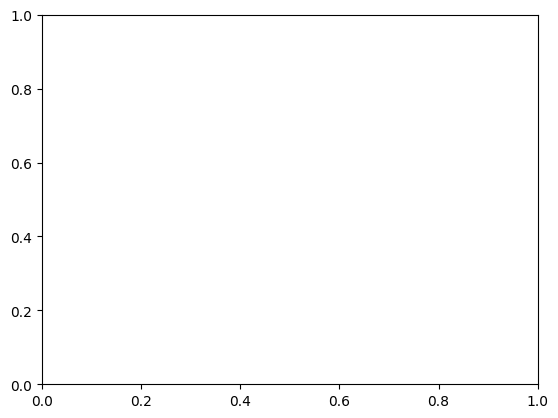

In [29]:
# plot the max and the mean angular displacement in a second by speed category
plt.plot(maxAngularDisplacementInASecondBySpeedCategory)
# plt.plot(meanAngularDisplacementInASecondBySpeedCategory, label="Mean Angular Velocity")
# plt.legend()
# plt.xlabel("Speed Category")
plt.ylabel(" Maximum Angular Velocity (degrees/second)")
plt.show()

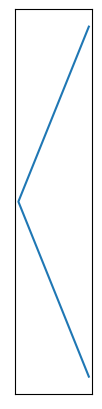

In [30]:
# plt.figure(figsize=(1, 5))
# draw to original scale
plt.figure(figsize=(1, 5))
t1 = [0, -.1, 0]
t2 = [0, 1, 2]
# no labels
plt.xticks([])
plt.yticks([])
plt.plot(t1, t2)

In [31]:
sumAngularDisplacementInASecond = angularStartingDf["absoluteAngularDisplacement"].rolling(10).sum()
sumAngularDisplacementInASecond

NameError: name 'angularStartingDf' is not defined

In [32]:
# find the max angular displacement for each speed category
def findMaxAngularDisplacement(df):
    # get the max angular displacement
    maxAngularDisplacement = df["relativeAngularDisplacement"].abs().max()
    return maxAngularDisplacement

maxAngularDisplacementDf = cleanPedDf.groupby('speedCategory').apply(findMaxAngularDisplacement)
maxAngularDisplacementDf

speedCategory
(0.0, 0.1]          NaN
(0.1, 0.2]          NaN
(0.2, 0.3]          NaN
(0.3, 0.4]          NaN
(0.4, 0.5]          NaN
(0.5, 0.6]     0.781956
(0.6, 0.7]     0.784789
(0.7, 0.8]     0.549545
(0.8, 0.9]          NaN
(0.9, 1.0]          NaN
(1.0, 1.1]          NaN
(1.1, 1.2]          NaN
(1.2, 1.3]          NaN
(1.3, 1.4]          NaN
(1.4, 1.5]          NaN
(1.5, 1.6]          NaN
(1.6, 1.7]          NaN
(1.7, 1.8]          NaN
(1.8, 1.9]          NaN
(1.9, 2.0]          NaN
(2.0, 10.0]         NaN
dtype: float64

In [ ]:
# find the max angular displacement for each speed category in each scene
def getMaxAngularDisplacementScenewise(sceneId, date, fps, dataDir, minYDisplacement, maxXDisplacement):
    pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
    tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))
    transformer = TrajectoryTransformer(colMapper)
    cleaner = TrajectoryCleaner(
        colMapper = colMapper,
        minSpeed = 0.0, # we can consider them as obstacles
        maxSpeed = 3.5,
        minAcceleration = 0.0,
        maxAcceleration = 2.0,   
        minYDisplacement = minYDisplacement,
        maxXDisplacement = maxXDisplacement
    )
    transformer.deriveSpeed(pedDf)
    transformer.deriveDisplacements(pedDf)
    transformer.deriveAcceleration(pedDf)
    cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
    
    allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
    transformer.translateAllToLocalSource(cleanPedDf)

    southIds = []
    for pedId in allPedIds:
        trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
        trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
        # print(trackMeta['verticalDirection'])
        if trackMeta['verticalDirection'] == "SOUTH":
            southIds.append(pedId)
            # print(trackMeta["uniqueTrackId"])
            X, Y = transformer.rotate(trackDf)
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
    # len(cleanPedDf)

    angularDisplacementDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)
    angularDisplacementDf['speedCategory'] = pd.cut(angularDisplacementDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])
    maxAngularDisplacementDf = angularDisplacementDf.groupby('speedCategory').apply(findMaxAngularDisplacement)
    return maxAngularDisplacementDf

scenes = [210, 211, 220, 221, 230, 231, 240, 222]
scenesMaxAngularDisplacement = []
for sceneId in scenes:
    scenesMaxAngularDisplacement.append(getMaxAngularDisplacementScenewise(sceneId, "2023-05-04", 10, dataDir, 5, 6))

using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)


ValueError: No objects to concatenate

In [ ]:
scenesMaxAngularDisplacementDf = pd.concat(scenesMaxAngularDisplacement, axis=1)
scenesMaxAngularDisplacementDf.columns = scenes[:5]
scenesMaxAngularDisplacementDf

In [ ]:
# plot distribution of angular displacement for each speed category
sns.displot(cleanPedDf, x="absoluteAngularDisplacement", hue="speedCategory", kind="kde", fill=True)
plt.xlabel("Absolute Angular Displacement")
plt.ylabel("Density")

plt.show()


In [ ]:
# write a function for getting the above plot for given sceneId
def getAngularDisplacementDistribution(sceneId, date, fps, dataDir, minYDisplacement, maxXDisplacement):
    pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
    tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))
    transformer = TrajectoryTransformer(colMapper)
    cleaner = TrajectoryCleaner(
        colMapper = colMapper,
        minSpeed = 0.0, # we can consider them as obstacles
        maxSpeed = 3.5,
        minAcceleration = 0.0,
        maxAcceleration = 2.0,   
        minYDisplacement = minYDisplacement,
        maxXDisplacement = maxXDisplacement
    )
    transformer.deriveSpeed(pedDf)
    transformer.deriveDisplacements(pedDf)
    transformer.deriveAcceleration(pedDf)
    cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
    
    allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
    transformer.translateAllToLocalSource(cleanPedDf)

    southIds = []
    for pedId in allPedIds:
        trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
        trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
        # print(trackMeta['verticalDirection'])
        if trackMeta['verticalDirection'] == "SOUTH":
            southIds.append(pedId)
            # print(trackMeta["uniqueTrackId"])
            X, Y = transformer.rotate(trackDf)
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
    # len(cleanPedDf)

    angularDisplacementDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)
    angularDisplacementDf['speedCategory'] = pd.cut(angularDisplacementDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])
    sns.displot(angularDisplacementDf, x="absoluteAngularDisplacement", hue="speedCategory", kind="kde", fill=True)
    plt.xlabel("Absolute Angular Displacement")
    plt.ylabel("Density")
    plt.title(f"Scene {sceneId}")
    plt.show()
    
getAngularDisplacementDistribution(210, "2023-05-04", 10, dataDir, 5, 6)

In [ ]:
# plot for all scenes from scenes array
scenes = [210, 211, 220, 221, 230, 231, 240, 222]
for sceneId in scenes:
    getAngularDisplacementDistribution(sceneId, "2023-05-04", 10, dataDir, 5, 6)

In [ ]:
NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

In [ ]:
def maxAngDisVsSpeed(dataframe):
    
    total_length = len(dataframe)
    maxAngularDisplacementDf = findMaxAngularDisplacementPedDf(dataframe)
    col1 = 'maxAngularDisplacement'
    col2 = 'Speed'

    maxAngularDisplacementDf['category1'] = assign_category(maxAngularDisplacementDf[col1], NO_OF_CATEGORY)
    maxAngularDisplacementDf['category2'] = assign_category(maxAngularDisplacementDf[col2], NO_OF_CATEGORY)

    heatmapDf = pd.DataFrame(columns = [col1, col2, 'count'])
    heatmapDf['maxAngularDisplacement'] = maxAngularDisplacementDf['category1']
    heatmapDf['Speed'] = maxAngularDisplacementDf['category2']
    heatmapDf['count'] = 1
    heatmapDf = heatmapDf.groupby(['maxAngularDisplacement', 'Speed']).count().reset_index()
    
    heatmapDf = heatmapDf.pivot(index='maxAngularDisplacement', columns='Speed', values='count')

    # heatmapDf_swap = find_RankA(heatmapDf)
    df = heatmapDf.iloc[::-1]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df/total_length, annot=True, fmt=".6f", cmap='YlGnBu')
    
    x_labels = ["low", "medium", "high"]
    y_labels = ["high", "medium", "low"]
    
    count = 3
    
    plt.xticks(np.arange(0.5, count+0.5, 1), x_labels)
    plt.yticks(np.arange(0.5, count+0.5, 1), y_labels)

    plt.xlabel("Speed")
    plt.ylabel("maxAngularDisplacement")

    plt.show()


In [ ]:
maxAngDisVsSpeed(cleanPedDf)